In [9]:
import pandas as pd
import os
from io import StringIO

# ✅ 실제 IDF 파일 경로 지정
idf_file = r"C:\Users\kjhye\Dropbox\Python\Sea Surface Tem(SSS)\XBT\XBT\202008_202012\XBT 수온자료 8~12월\OMAS_PROFILE_20200805_141630_962.IDF"

# 파일 읽기
with open(idf_file, "r", encoding="latin1") as f:
    lines = f.readlines()

# "Longitude" 행을 찾아서 이후 부분만 데이터로 사용
for i, line in enumerate(lines):
    if line.strip().startswith("Longitude"):
        data_start = i
        break

# 데이터 부분만 Pandas DataFrame으로 변환
data_str = "".join(lines[data_start:])
df = pd.read_csv(StringIO(data_str), sep="\t")

print(df.head())


                                           Longitude   Latitude  \
0  ----------------------------------------------...        NaN   
1                                         124510000E  37340000N   
2                                         124510000E  37340000N   
3                                         124510000E  37340000N   
4                                         124510000E  37340000N   

              Time  Depth  Temperature  
0              NaN    NaN          NaN  
1  20200804_200000    0.0        21.70  
2  20200804_200000    2.0        21.50  
3  20200804_200000    4.0        21.30  
4  20200804_200000    6.0        21.18  


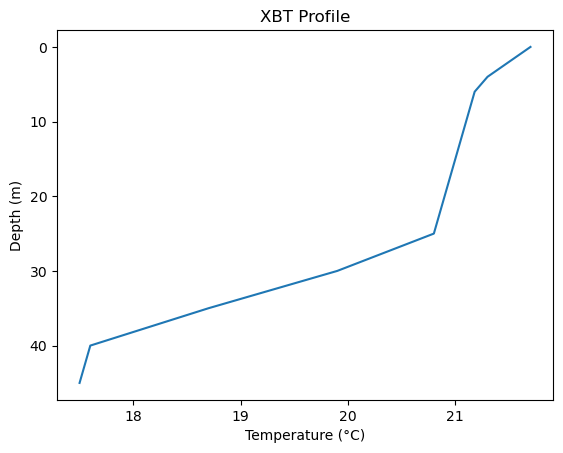

In [10]:
import matplotlib.pyplot as plt

plt.plot(df["Temperature"], df["Depth"])
plt.gca().invert_yaxis()  # 깊이는 아래로 갈수록 커지므로 y축 반전
plt.xlabel("Temperature (°C)")
plt.ylabel("Depth (m)")
plt.title("XBT Profile")
plt.show()


In [11]:
import pandas as pd
import os
import glob
from io import StringIO

# 2019~2020 폴더 경로 지정
base_folder = r"C:\Users\kjhye\Dropbox\Python\Sea Surface Tem(SSS)\XBT\XBT\201901_202008"

all_files = glob.glob(os.path.join(base_folder, "**", "*.IDF"), recursive=True)

records = []
for file in all_files:
    with open(file, "r", encoding="latin1") as f:
        lines = f.readlines()
    # 데이터 시작 위치 찾기
    for i, line in enumerate(lines):
        if line.strip().startswith("Longitude"):
            data_start = i
            break
    data_str = "".join(lines[data_start:])
    df = pd.read_csv(StringIO(data_str), sep="\t")
    
    # 파일명에서 날짜 추출 (예: OMAS_PROFILE_20190805_141630_962.IDF → 20190805)
    fname = os.path.basename(file)
    date_str = fname.split("_")[2]  # "20190805"
    date = pd.to_datetime(date_str, format="%Y%m%d")
    
    # 표층 수온 (Depth=0m, 없으면 가장 얕은 값 선택)
    surface_temp = df.loc[df["Depth"].idxmin(), "Temperature"]
    
    records.append({"date": date, "sst": surface_temp})

# 시계열 DataFrame
ts = pd.DataFrame(records).sort_values("date").set_index("date")
print(ts.head())


             sst
date            
2019-01-01  12.8
2019-01-01  14.5
2019-01-01  10.3
2019-01-01  14.3
2019-01-01   7.9


             sst
date            
2019-01-01  12.8
2019-01-01  14.5
2019-01-01  10.3
2019-01-01  14.3
2019-01-01   7.9


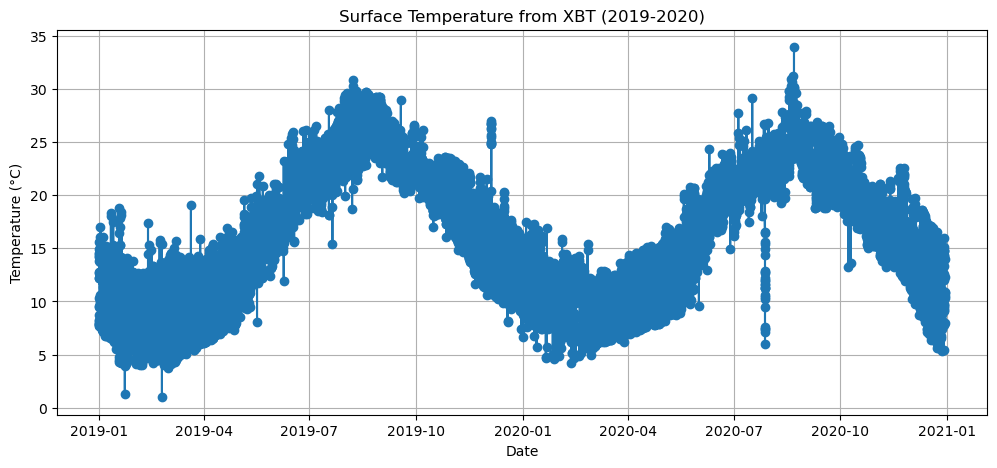

C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    sst   No. Observations:                17837
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -38696.889
Date:                Thu, 02 Oct 2025   AIC                          77399.778
Time:                        14:28:23   BIC                          77423.145
Sample:                             0   HQIC                         77407.466
                              - 17837                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0461      0.006      7.136      0.000       0.033       0.059
ma.L1         -0.9607      0.001   -749.082      0.000      -0.963      -0.958
sigma2         4.4869      0.046     97.597      0.0

C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\kjhye\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


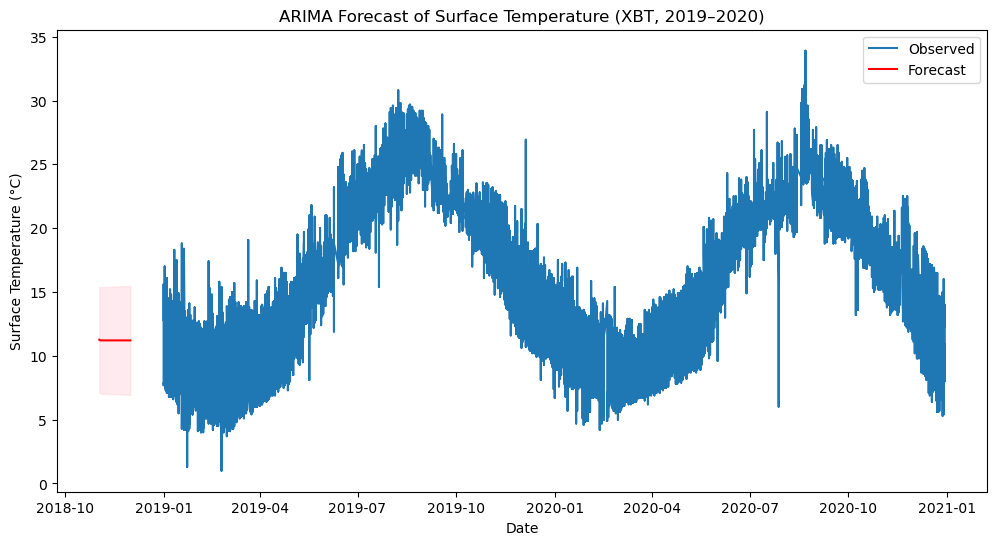

In [12]:
import pandas as pd
import os
import glob
from io import StringIO
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# -----------------------------------------------------
# 1. 2019~2020 XBT 파일 읽어서 표층 수온 추출
# -----------------------------------------------------
base_folder = r"C:\Users\kjhye\Dropbox\Python\Sea Surface Tem(SSS)\XBT\XBT\201901_202008"

all_files = glob.glob(os.path.join(base_folder, "**", "*.IDF"), recursive=True)

records = []
for file in all_files:
    with open(file, "r", encoding="latin1") as f:
        lines = f.readlines()
    # 데이터 시작 줄 찾기
    for i, line in enumerate(lines):
        if line.strip().startswith("Longitude"):
            data_start = i
            break
    data_str = "".join(lines[data_start:])
    df = pd.read_csv(StringIO(data_str), sep="\t")
    
    # 파일명에서 날짜 추출 (OMAS_PROFILE_20190805_141630_962.IDF → 20190805)
    fname = os.path.basename(file)
    date_str = fname.split("_")[2]  # "20190805"
    date = pd.to_datetime(date_str, format="%Y%m%d")
    
    # 표층(Depth=0m, 없으면 가장 얕은 값)
    surface_temp = df.loc[df["Depth"].idxmin(), "Temperature"]
    
    records.append({"date": date, "sst": surface_temp})

# DataFrame 생성 및 시계열 정렬
ts = pd.DataFrame(records).sort_values("date").set_index("date")
print(ts.head())

# -----------------------------------------------------
# 2. 시계열 시각화 (원자료)
# -----------------------------------------------------
plt.figure(figsize=(12,5))
plt.plot(ts.index, ts["sst"], marker="o", linestyle="-")
plt.title("Surface Temperature from XBT (2019-2020)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()

# -----------------------------------------------------
# 3. ARIMA 모델 적합
# -----------------------------------------------------
# 간단히 (1,1,1) 사용, 필요시 auto_arima로 모수 탐색 가능
model = ARIMA(ts["sst"], order=(1,1,1))
fit = model.fit()

print(fit.summary())

# -----------------------------------------------------
# 4. 예측 및 시각화
# -----------------------------------------------------
forecast = fit.get_forecast(steps=30)   # 30일 미래 예측
pred = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(12,6))
plt.plot(ts.index, ts["sst"], label="Observed")
plt.plot(pred.index, pred, label="Forecast", color="red")
plt.fill_between(conf_int.index,
                 conf_int.iloc[:,0],
                 conf_int.iloc[:,1],
                 color="pink", alpha=0.3)
plt.title("ARIMA Forecast of Surface Temperature (XBT, 2019–2020)")
plt.xlabel("Date")
plt.ylabel("Surface Temperature (°C)")
plt.legend()
plt.show()


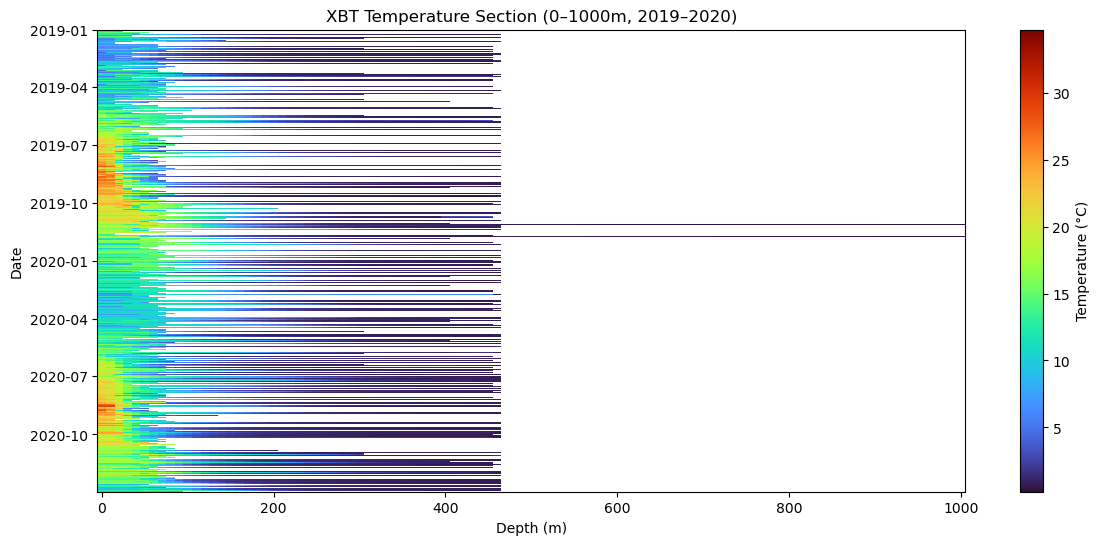

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from io import StringIO

# -----------------------------------------------------
# 1. XBT 파일 불러오기 (2019~2020년 예시)
# -----------------------------------------------------
base_folder = r"C:\Users\kjhye\Dropbox\Python\Sea Surface Tem(SSS)\XBT\XBT\201901_202008"
all_files = glob.glob(os.path.join(base_folder, "**", "*.IDF"), recursive=True)

records = []
for file in all_files:
    with open(file, "r", encoding="latin1") as f:
        lines = f.readlines()
    # 데이터 시작 줄 찾기
    for i, line in enumerate(lines):
        if line.strip().startswith("Longitude"):
            data_start = i
            break
    data_str = "".join(lines[data_start:])
    df = pd.read_csv(StringIO(data_str), sep="\t")

    # 날짜 추출
    fname = os.path.basename(file)
    date_str = fname.split("_")[2]
    date = pd.to_datetime(date_str, format="%Y%m%d")

    # 깊이–온도 값만 추출
    for _, row in df.iterrows():
        if 0 <= row["Depth"] <= 1000:  # 0~1000m만
            records.append({"date": date, "depth": row["Depth"], "temp": row["Temperature"]})

df_all = pd.DataFrame(records)

# -----------------------------------------------------
# 2. 날짜별로 깊이 보간 (0~1000m, 10m 간격)
# -----------------------------------------------------
depth_grid = np.arange(0, 1001, 10)  # 0~1000m, 10m 간격
interp_records = []

for date, group in df_all.groupby("date"):
    d = group["depth"].values
    t = group["temp"].values
    if len(d) < 2:  # 깊이 데이터가 너무 적으면 건너뜀
        continue
    temp_interp = np.interp(depth_grid, d, t, left=np.nan, right=np.nan)
    for z, temp in zip(depth_grid, temp_interp):
        interp_records.append({"date": date, "depth": z, "temp": temp})

df_interp = pd.DataFrame(interp_records)

# -----------------------------------------------------
# 3. Pivot → Heatmap
# -----------------------------------------------------
pivot = df_interp.pivot_table(index="date", columns="depth", values="temp")

plt.figure(figsize=(14,6))
X, Y = np.meshgrid(pivot.columns, pivot.index)
plt.pcolormesh(X, Y, pivot.values, shading="auto", cmap="turbo")

plt.gca().invert_yaxis()  # 깊이는 아래로 갈수록 증가
plt.colorbar(label="Temperature (°C)")
plt.xlabel("Depth (m)")
plt.ylabel("Date")
plt.title("XBT Temperature Section (0–1000m, 2019–2020)")
plt.show()


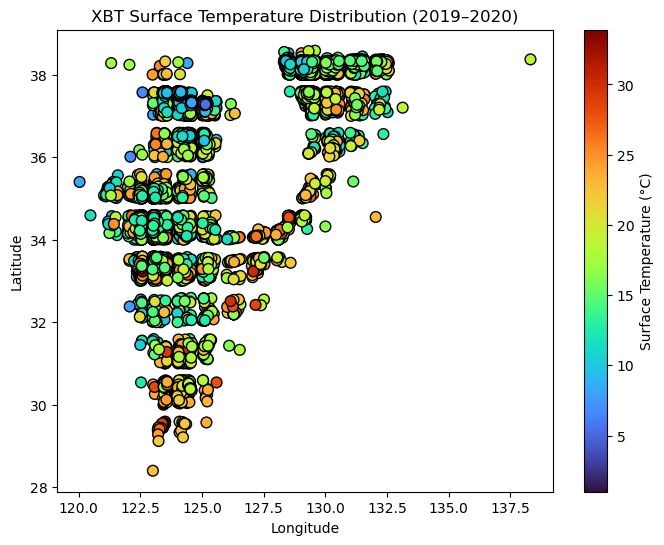

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import glob, os
from io import StringIO

base_folder = r"C:\Users\kjhye\Dropbox\Python\Sea Surface Tem(SSS)\XBT\XBT\201901_202008"
all_files = glob.glob(os.path.join(base_folder, "**", "*.IDF"), recursive=True)

records = []
for file in all_files:
    with open(file, "r", encoding="latin1") as f:
        lines = f.readlines()
    for i, line in enumerate(lines):
        if line.strip().startswith("Longitude"):
            data_start = i
            break
    data_str = "".join(lines[data_start:])

    # 데이터프레임 읽기 (불필요한 '-' 라인 제거)
    df = pd.read_csv(StringIO(data_str), sep="\t")
    df = df[~df["Longitude"].astype(str).str.contains("-")]   # ----- 제거

    # 날짜 추출
    fname = os.path.basename(file)
    date_str = fname.split("_")[2]
    date = pd.to_datetime(date_str, format="%Y%m%d")

    # 표층 수온 (Depth=0m, 없으면 가장 얕은 값)
    surface_temp = df.loc[df["Depth"].idxmin(), "Temperature"]

    # 경위도 추출
    lon = str(df["Longitude"].iloc[0]).strip()
    lat = str(df["Latitude"].iloc[0]).strip()

    # 문자열 → 숫자 변환
    lon_val = int(lon[:-1]) / 1e6
    if lon.endswith("W"): lon_val = -lon_val
    lat_val = int(lat[:-1]) / 1e6
    if lat.endswith("S"): lat_val = -lat_val

    records.append({"date": date, "lon": lon_val, "lat": lat_val, "sst": surface_temp})

df_map = pd.DataFrame(records)

# -----------------------------------------------------
# 2D Heatmap (경도–위도 산점도)
# -----------------------------------------------------
plt.figure(figsize=(8,6))
sc = plt.scatter(df_map["lon"], df_map["lat"], c=df_map["sst"],
                 cmap="turbo", s=60, edgecolor="k")
plt.colorbar(sc, label="Surface Temperature (°C)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("XBT Surface Temperature Distribution (2019–2020)")
plt.show()


In [2]:
# --- 0) 패키지 ---
import os, glob
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from joblib import Parallel, delayed

# --- 1) 경로/설정 ---
# (A) 선배 예시1: 필터된 2020-06~08 표층 CSV
# csv_path = r"C:\...\filtered_depth0_20200601_20200807.csv"  # 필요시 사용

# (B) 선배 예시2: 2017~2020-01 전체 표층 CSV
csv_path = r"C:\Users\kjhye\Dropbox\Python\Sea Surface Tem(SSS)\data\dataset_2017_to_2020-01\depth_0p0.csv"  # 선호 경로로 교체

# 학습/검증 분할 기준 (선배 코드와 동일 기본값: 2019-01-01)
cutoff = pd.Timestamp(2019,1,1)

# 중복 취급: 'max' = 같은 (y,x,t)에서 온도의 최댓값 사용 / 'last' = 마지막 값으로 덮어쓰기
dedup_strategy = 'last'  # 'max' 또는 'last'

# 위도 하향 샘플링(선배 코드에 1:2:end 사례가 있어 옵션화)
downsample_lat_by2 = False

# ARIMA 파라미터(격자별 공통). 먼저 (1,1,1)로 고정, 필요시 auto_arima로 확장 가능
arima_order = (1,1,1)

# --- 2) CSV 로드 & 선배 전처리 재현 ---
# depth 컬럼 드랍(=표층만), lat/lon 반올림, 시간 파싱
_data = pd.read_csv(csv_path)
if "depth" in _data.columns:
    _data = _data.drop(columns=["depth"])

# 컬럼 이름 통일(선배 스크립트와 호환: lat, lon, time, temp/temperature 등)
# 가능한 이름 추정/정규화
rename_map = {}
for c in _data.columns:
    lc = c.lower()
    if lc.startswith("lat"): rename_map[c] = "lat"
    elif lc.startswith("lon"): rename_map[c] = "lon"
    elif lc.startswith("time"): rename_map[c] = "time"
    elif lc in ("temp","temperature","sst","z"): rename_map[c] = "z"
_data = _data.rename(columns=rename_map)

# 필수 컬럼 체크
need_cols = {"lat","lon","time","z"}
miss = need_cols - set(_data.columns)
if miss:
    raise ValueError(f"필수 컬럼 누락: {miss}. CSV의 실제 컬럼명을 알려주면 매핑해 드릴게요.")

# 반올림 & 시간 파싱
_data["lat"] = _data["lat"].round(2)
_data["lon"] = _data["lon"].round(2)
# 선배 형식: yyyy-mm-dd HH:MM:SS
_data["time"] = pd.to_datetime(_data["time"], format="%Y-%m-%d %H:%M:%S", errors="coerce")
# 파싱 실패는 자동 처리
_data = _data.dropna(subset=["time"])

# 학습/검증 분리용 축 생성
T = np.sort(_data["time"].unique())
Y = np.sort(_data["lat"].unique())
X = np.sort(_data["lon"].unique())

# 인덱스로 매핑(선배 코드 rename! → t,y,x,z 후 Dict 매핑)
_data = _data.rename(columns={"time":"t","lat":"y","lon":"x"})
t_map = {t:i for i,t in enumerate(T)}       # 0..nT-1
y_map = {y:i for i,y in enumerate(Y)}       # 0..nY-1
x_map = {x:i for i,x in enumerate(X)}       # 0..nX-1

_data["ti"] = _data["t"].map(t_map)
_data["yi"] = _data["y"].map(y_map)
_data["xi"] = _data["x"].map(x_map)

nT, nY, nX = len(T), len(Y), len(X)

# 텐서 채우기: (y,x,t) → z
tnsr = np.zeros((nY, nX, nT), dtype=float)

if dedup_strategy == 'max':
    # 같은 격자/시간 중복 시 최댓값
    # (줄리아에서 max 사용한 예)  :contentReference[oaicite:8]{index=8}
    for yi, xi, ti, z in _data[["yi","xi","ti","z"]].itertuples(index=False):
        if z > tnsr[yi, xi, ti]:
            tnsr[yi, xi, ti] = z
else:
    # 덮어쓰기(마지막 값) — 줄리아 다른 스크립트의 기본 루프와 동일  :contentReference[oaicite:9]{index=9} :contentReference[oaicite:10]{index=10}
    for yi, xi, ti, z in _data[["yi","xi","ti","z"]].itertuples(index=False):
        tnsr[yi, xi, ti] = z

# (선택) 위도 방향 1:2:end 하향 샘플링  :contentReference[oaicite:11]{index=11}
if downsample_lat_by2:
    tnsr = tnsr[::2, :, :]
    Y = Y[::2]
    nY = len(Y)

# --- 3) 학습/검증 분할 ---
cut_trng = np.max(np.where(T < np.datetime64(cutoff))[0]) if np.any(T < np.datetime64(cutoff)) else (nT-1)
# 학습 구간: [0 ... cut_trng],  테스트 구간: [cut_trng+1 ... end]
trng = tnsr[:, :, :cut_trng+1]
test = tnsr[:, :, cut_trng+1:]
T_train = T[:cut_trng+1]
T_test  = T[cut_trng+1:]

print(f"학습 길이={trng.shape[2]}, 테스트 길이={test.shape[2]}, 격자={nY}x{nX}")

# --- 4) 격자별 ARIMA 학습/예측 ---
def fit_forecast_one(yx_series, steps, order):
    # 시계열이 모두 0이거나 유효 포인트 적으면 그대로 0 예측
    if np.all(np.isnan(yx_series)) or np.allclose(yx_series, 0):
        return np.zeros(steps), None
    # 결측 보간(단순): 앞/뒤 채움
    s = pd.Series(yx_series).replace([np.inf, -np.inf], np.nan).interpolate(limit_direction="both")
    try:
        model = ARIMA(s.values, order=order)
        res = model.fit()
        fc = res.forecast(steps=steps)
        return np.asarray(fc), res
    except Exception:
        # 실패 시 마지막 관측치로 평탄 예측
        return np.repeat(s.values[-1], steps), None

steps = test.shape[2]
pred  = np.zeros_like(test)

# 병렬(선택) — 격자별로 학습/예측
def run_cell(i,j):
    fc, _ = fit_forecast_one(trng[i,j,:], steps, arima_order)
    return (i, j, fc)

out = Parallel(n_jobs=-1, backend="loky")(delayed(run_cell)(i,j) for i in range(nY) for j in range(nX))
for i, j, fc in out:
    pred[i,j,:] = fc

# --- 5) 평가(예: MAE 시계열 & 특정 시각 단면 시각화) ---
mae_t = np.nanmean(np.abs(test - pred), axis=(0,1))  # 시간별 MAE
plt.figure(figsize=(10,3)); plt.plot(T_test, mae_t); plt.title("Time-wise MAE"); plt.tight_layout(); plt.show()

# 특정 테스트 시점 k의 실제/예측/오차 heatmap
k = min(5, steps-1)
vmin = np.nanpercentile(test[:,:,k], 5); vmax = np.nanpercentile(test[:,:,k], 95)

plt.figure(figsize=(12,3.5))
plt.subplot(1,3,1); plt.imshow(test[:,:,k], aspect="auto", vmin=vmin, vmax=vmax); plt.title("Actual (test)"); plt.colorbar()
plt.subplot(1,3,2); plt.imshow(pred[:,:,k], aspect="auto", vmin=vmin, vmax=vmax); plt.title("ARIMA forecast"); plt.colorbar()
plt.subplot(1,3,3); plt.imshow(test[:,:,k]-pred[:,:,k], aspect="auto", cmap="bwr"); plt.title("Residual"); plt.colorbar()
plt.tight_layout(); plt.show()

# --- 6) (옵션) 애니메이션/저장 포맷은 필요 시 추가 ---


ValueError: 필수 컬럼 누락: {'z'}. CSV의 실제 컬럼명을 알려주면 매핑해 드릴게요.

In [3]:
import pandas as pd

csv_path = r"C:\Users\kjhye\Dropbox\Python\Sea Surface Tem(SSS)\XBT\XBT\201901_202008\data.csv"   # 네가 사용중인 파일명으로 바꿔
df = pd.read_csv(csv_path)

print(df.columns)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\kjhye\\Dropbox\\Python\\Sea Surface Tem(SSS)\\XBT\\XBT\\201901_202008\\data.csv'

In [4]:
import os

folder = r"C:\Users\kjhye\Dropbox\Python\Sea Surface Tem(SSS)\XBT\XBT\201901_202008"

print(os.listdir(folder))

['2019', '2020']
